# Forecasting Walmart Sales

### **Table of Contents**
* [<span style="color:#A690A4"> 0. Executive Summary](#exe_sum)
* [<span style="color:#A690A4"> 1. Introduction](#intro)
* [<span style="color:#A690A4"> 2. Collect & Clean Data](#collect)
* [<span style="color:#A690A4"> 2. Wrangle & Explore Data](#process)
* [<span style="color:#A690A4"> 3. Forecast Sales](#predict)
* [<span style="color:#A690A4"> 4. Conclusion](#conclusion)

# <span style="color:#5E6997">Executive Summary</span> <a class="anchor" id="exe_sum"></a>

# <span style="color:#5E6997">Introduction</span> <a class="anchor" id="intro"></a>

# <span style="color:#5E6997">Collect & Clean Data</span> <a class="anchor" id="collect"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-sales-forecast/features.csv
/kaggle/input/walmart-sales-forecast/stores.csv
/kaggle/input/walmart-sales-forecast/train.csv
/kaggle/input/walmart-sales-forecast/test.csv


In [2]:
# Define file paths
features_path = "/kaggle/input/walmart-sales-forecast/features.csv"
stores_path   = "/kaggle/input/walmart-sales-forecast/stores.csv"
train_path    = "/kaggle/input/walmart-sales-forecast/train.csv"
test_path     = "/kaggle/input/walmart-sales-forecast/test.csv"

# Load datasets
features = pd.read_csv(features_path)
stores   = pd.read_csv(stores_path)
train    = pd.read_csv(train_path)
test     = pd.read_csv(test_path)

In [3]:
# Convert the 'Date' column to datetime format
features["Date"] = pd.to_datetime(features["Date"], format="%Y-%m-%d")
train["Date"] = pd.to_datetime(train["Date"], format="%Y-%m-%d")
test["Date"] = pd.to_datetime(test["Date"], format="%Y-%m-%d")

### Store Data

In [4]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
stores.tail()

,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


In [6]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [7]:
def display_feature_range(df):
    """
    Display the range of values for each column in a DataFrame.
    For numeric (non-boolean) columns, prints the minimum, maximum, and range.
    For non-numeric or boolean columns, prints the unique values.
    """
    for col in df.columns:
        print("=" * 40)
        print(f"Feature: {col}")
        
        # Check for numeric columns excluding booleans
        if pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_bool_dtype(df[col]):
            col_min = df[col].min()
            col_max = df[col].max()
            print(f"Min: {col_min}")
            print(f"Max: {col_max}")
            print(f"Range: {col_max - col_min}")
        else:
            unique_vals = df[col].unique()
            print("Unique values:", unique_vals)
        print("=" * 40, "\n")

In [8]:
# Call the function with the stores dataset
display_feature_range(stores)

Feature: Store
Min: 1
Max: 45
Range: 44

Feature: Type
Unique values: ['A' 'B' 'C']

Feature: Size
Min: 34875
Max: 219622
Range: 184747



### Features Data

In [9]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [10]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [11]:
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [12]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 712.0 KB


In [13]:
# Define the list of MarkDown columns
markdown_cols = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]

# Fill missing values in the MarkDown columns with 0
features[markdown_cols] = features[markdown_cols].fillna(0)

# Optionally, display info to verify that missing values have been filled
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     8190 non-null   float64       
 5   MarkDown2     8190 non-null   float64       
 6   MarkDown3     8190 non-null   float64       
 7   MarkDown4     8190 non-null   float64       
 8   MarkDown5     8190 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 712.0 KB


In [14]:
# Create boolean masks where True indicates a missing value
mask_cpi = features['CPI'].isna()
mask_unemployment = features['Unemployment'].isna()

# Check if both masks are exactly the same
if mask_cpi.equals(mask_unemployment):
    print("CPI and Unemployment have the exact same missing value pattern.")
else:
    print("CPI and Unemployment have different missing value patterns.")

CPI and Unemployment have the exact same missing value pattern.


In [15]:
# Rows where CPI  is missing
missing_mask = features['CPI'].isna() 
missing_rows = features[missing_mask]
print(missing_rows)

      Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
169       1 2013-05-03        66.66       3.386    2298.63       2.00   
170       1 2013-05-10        63.90       3.392    4624.61      83.88   
171       1 2013-05-17        69.53       3.454   16170.50      92.00   
172       1 2013-05-24        77.19       3.494    7959.89     178.00   
173       1 2013-05-31        78.02       3.466    2369.77     142.45   
...     ...        ...          ...         ...        ...        ...   
8185     45 2013-06-28        76.05       3.639    4842.29     975.03   
8186     45 2013-07-05        77.50       3.614    9090.48    2268.58   
8187     45 2013-07-12        79.37       3.614    3789.94    1827.31   
8188     45 2013-07-19        82.84       3.737    2961.49    1047.07   
8189     45 2013-07-26        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5  CPI  Unemployment  IsHoliday  
169      129.90      55.46    1301.04  NaN           

In [16]:
# Focus on Store 1 (or whichever store is plotted)
store1 = features[features['Store'] == 1].copy()
store1 = store1.sort_values('Date')

# Inspect data for the time frame around the suspicious jump
suspicious_range = store1[(store1['Date'] >= "2013-04-01") & (store1['Date'] <= "2013-08-31")]
print(suspicious_range[['Date', 'CPI']])

          Date        CPI
165 2013-04-05  225.08654
166 2013-04-12  225.17016
167 2013-04-19  225.17016
168 2013-04-26  225.17016
169 2013-05-03        NaN
170 2013-05-10        NaN
171 2013-05-17        NaN
172 2013-05-24        NaN
173 2013-05-31        NaN
174 2013-06-07        NaN
175 2013-06-14        NaN
176 2013-06-21        NaN
177 2013-06-28        NaN
178 2013-07-05        NaN
179 2013-07-12        NaN
180 2013-07-19        NaN
181 2013-07-26        NaN


In [17]:
print(features[['Date', 'Store', 'CPI', 'Unemployment']].tail(30))

           Date  Store         CPI  Unemployment
8160 2013-01-04     45  192.659622         8.625
8161 2013-01-11     45  192.759980         8.625
8162 2013-01-18     45  192.809507         8.625
8163 2013-01-25     45  192.838701         8.625
8164 2013-02-01     45  192.867895         8.625
8165 2013-02-08     45  192.897089         8.625
8166 2013-02-15     45  192.943471         8.625
8167 2013-02-22     45  193.032822         8.625
8168 2013-03-01     45  193.122173         8.625
8169 2013-03-08     45  193.211524         8.625
8170 2013-03-15     45  193.296277         8.625
8171 2013-03-22     45  193.369533         8.625
8172 2013-03-29     45  193.442790         8.625
8173 2013-04-05     45  193.516047         8.335
8174 2013-04-12     45  193.589304         8.335
8175 2013-04-19     45  193.589304         8.335
8176 2013-04-26     45  193.589304         8.335
8177 2013-05-03     45         NaN           NaN
8178 2013-05-10     45         NaN           NaN
8179 2013-05-17     

In [18]:
# Set Date as the index for interpolation
features.set_index("Date", inplace=True)

# Step 1: Apply Forward-Fill and Backward-Fill at the Global Level
features[['CPI', 'Unemployment']] = features[['CPI', 'Unemployment']].ffill().bfill()

# Step 2: Apply Linear Interpolation Per Store
features = (
    features.groupby("Store", group_keys=False)  # Ensure per-store interpolation
            .apply(lambda g: g.interpolate(method='linear', limit_direction='both'))  
)

# Reset index so Date becomes a column again
features.reset_index(inplace=True)

<ipython-input-18-80f2677e93c6>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.interpolate(method='linear', limit_direction='both'))


In [19]:
print(features[['Date', 'CPI', 'Unemployment']].tail(30))

           Date         CPI  Unemployment
8160 2013-01-04  192.659622         8.625
8161 2013-01-11  192.759980         8.625
8162 2013-01-18  192.809507         8.625
8163 2013-01-25  192.838701         8.625
8164 2013-02-01  192.867895         8.625
8165 2013-02-08  192.897089         8.625
8166 2013-02-15  192.943471         8.625
8167 2013-02-22  193.032822         8.625
8168 2013-03-01  193.122173         8.625
8169 2013-03-08  193.211524         8.625
8170 2013-03-15  193.296277         8.625
8171 2013-03-22  193.369533         8.625
8172 2013-03-29  193.442790         8.625
8173 2013-04-05  193.516047         8.335
8174 2013-04-12  193.589304         8.335
8175 2013-04-19  193.589304         8.335
8176 2013-04-26  193.589304         8.335
8177 2013-05-03  193.589304         8.335
8178 2013-05-10  193.589304         8.335
8179 2013-05-17  193.589304         8.335
8180 2013-05-24  193.589304         8.335
8181 2013-05-31  193.589304         8.335
8182 2013-06-07  193.589304       

In [20]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          8190 non-null   datetime64[ns]
 1   Store         8190 non-null   int64         
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     8190 non-null   float64       
 5   MarkDown2     8190 non-null   float64       
 6   MarkDown3     8190 non-null   float64       
 7   MarkDown4     8190 non-null   float64       
 8   MarkDown5     8190 non-null   float64       
 9   CPI           8190 non-null   float64       
 10  Unemployment  8190 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 712.0 KB


<ipython-input-21-9b373cd380b2>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index("Date").interpolate(method='linear', limit_direction='both').reset_index())


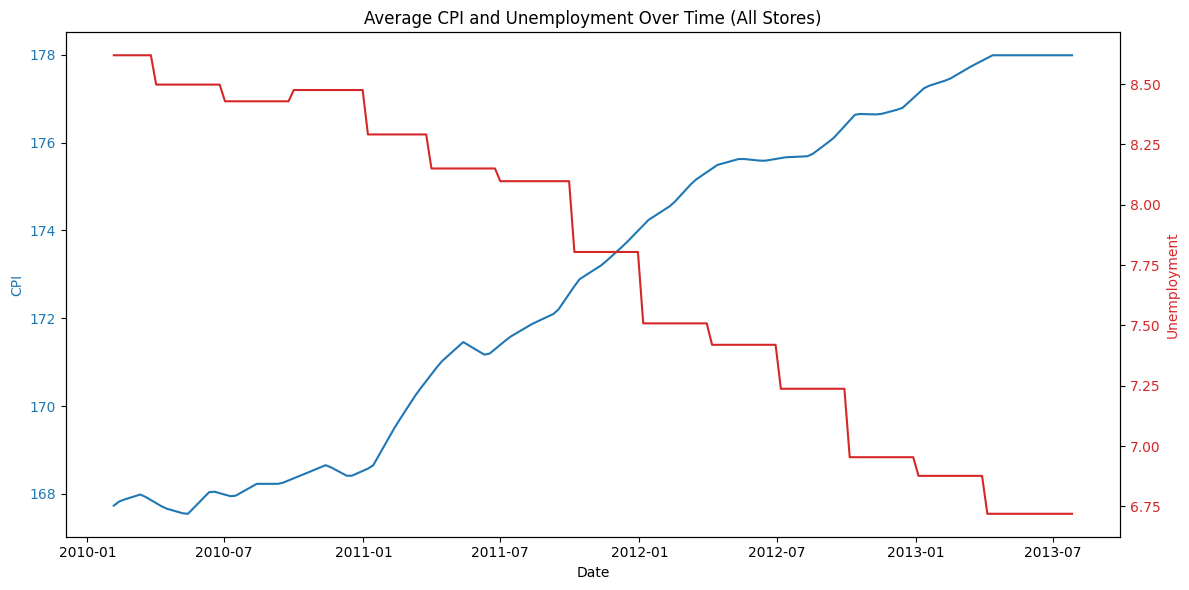

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Ensure Date is in datetime format
features['Date'] = pd.to_datetime(features['Date'])

# 2. Sort by Store and Date (only needed once)
features.sort_values(["Store", "Date"], inplace=True)

# 3. Apply Linear Interpolation Per Store (Fix: Use "Date" as the index)
features = (
    features.groupby("Store", group_keys=False)  # Group by store
            .apply(lambda g: g.set_index("Date").interpolate(method='linear', limit_direction='both').reset_index())  
)

# 4. Aggregate to get daily averages across all stores (ensuring one row per date)
daily_avg = features.groupby('Date', as_index=False).agg({
    'CPI': 'mean',
    'Unemployment': 'mean'
})
daily_avg.sort_values('Date', inplace=True)

# 5. Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12,6))

# CPI on primary y-axis
color_cpi = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("CPI", color=color_cpi)
ax1.plot(daily_avg['Date'], daily_avg['CPI'], color=color_cpi, label='Avg CPI')
ax1.tick_params(axis='y', labelcolor=color_cpi)

# Unemployment on secondary y-axis
ax2 = ax1.twinx()
color_unemp = 'tab:red'
ax2.set_ylabel("Unemployment", color=color_unemp)
ax2.plot(daily_avg['Date'], daily_avg['Unemployment'], color=color_unemp, label='Avg Unemployment')
ax2.tick_params(axis='y', labelcolor=color_unemp)

plt.title("Average CPI and Unemployment Over Time (All Stores)")
fig.tight_layout()
plt.savefig("CPI_Unemployment_all_stores.jpg", format="jpg", dpi=300)
plt.show()


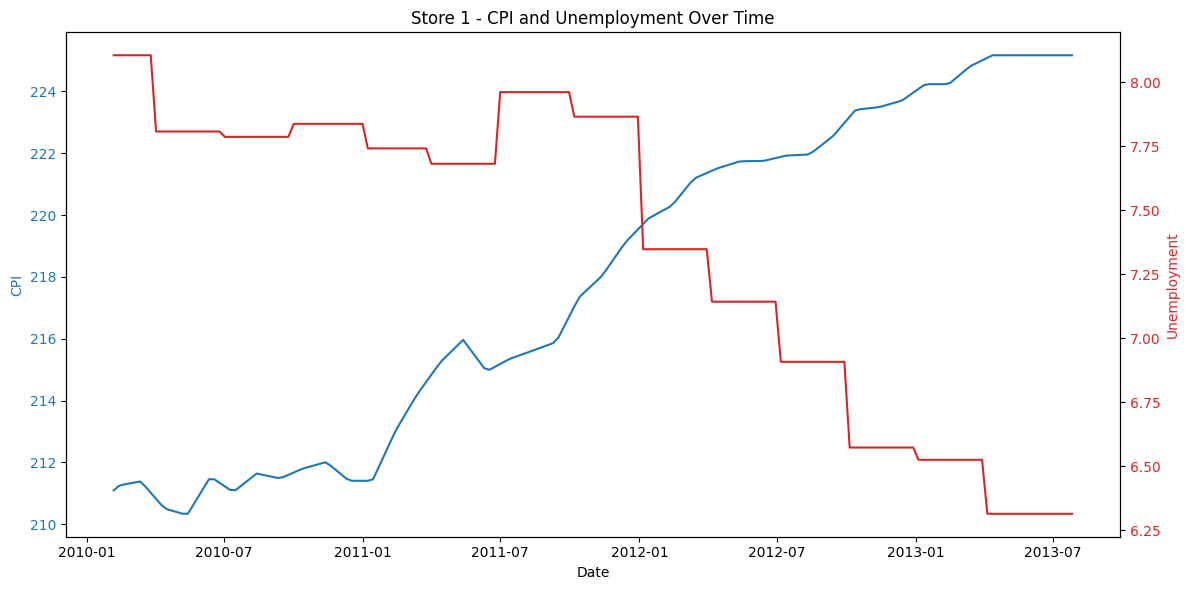

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'features' is your DataFrame with interpolated CPI and Unemployment

# Choose the store you want to visualize (e.g., Store 1)
store_id = 1
store_df = features[features['Store'] == store_id].copy()

# Sort by Date to ensure the time series is in order
store_df.sort_values('Date', inplace=True)

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot CPI on the primary y-axis
color_cpi = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("CPI", color=color_cpi)
ax1.plot(store_df['Date'], store_df['CPI'], color=color_cpi, label='CPI')
ax1.tick_params(axis='y', labelcolor=color_cpi)

# Create a second y-axis for Unemployment
ax2 = ax1.twinx()
color_unemp = 'tab:red'
ax2.set_ylabel("Unemployment", color=color_unemp)
ax2.plot(store_df['Date'], store_df['Unemployment'], color=color_unemp, label='Unemployment')
ax2.tick_params(axis='y', labelcolor=color_unemp)

plt.title(f"Store {store_id} - CPI and Unemployment Over Time")
fig.tight_layout()
plt.savefig(f"Store_{store_id}_CPI_Unemployment_store_1.jpg", format="jpg", dpi=300)
plt.show()


In [23]:
# Focus on a time range around the jump
check_range = daily_avg[(daily_avg['Date'] >= "2013-05-01") & (daily_avg['Date'] <= "2013-08-01")]
print(check_range)

          Date        CPI  Unemployment
169 2013-05-03  177.99068      6.719244
170 2013-05-10  177.99068      6.719244
171 2013-05-17  177.99068      6.719244
172 2013-05-24  177.99068      6.719244
173 2013-05-31  177.99068      6.719244
174 2013-06-07  177.99068      6.719244
175 2013-06-14  177.99068      6.719244
176 2013-06-21  177.99068      6.719244
177 2013-06-28  177.99068      6.719244
178 2013-07-05  177.99068      6.719244
179 2013-07-12  177.99068      6.719244
180 2013-07-19  177.99068      6.719244
181 2013-07-26  177.99068      6.719244


In [24]:
print(daily_avg[['CPI', 'Unemployment']].describe())

              CPI  Unemployment
count  182.000000    182.000000
mean   172.855800      7.747708
std      3.689152      0.647174
min    167.546485      6.719244
25%    168.582724      7.237333
50%    173.084948      7.804222
75%    176.086612      8.428578
max    177.990680      8.619311


In [25]:
# Check CPI and Unemployment for a wider range to see available data points
check_surrounding = daily_avg[(daily_avg['Date'] >= "2013-01-01") & (daily_avg['Date'] <= "2013-12-01")]
print(check_surrounding)

          Date         CPI  Unemployment
152 2013-01-04  177.125367      6.876444
153 2013-01-11  177.235667      6.876444
154 2013-01-18  177.295004      6.876444
155 2013-01-25  177.333956      6.876444
156 2013-02-01  177.372908      6.876444
157 2013-02-08  177.411860      6.876444
158 2013-02-15  177.459922      6.876444
159 2013-02-22  177.530760      6.876444
160 2013-03-01  177.601597      6.876444
161 2013-03-08  177.672434      6.876444
162 2013-03-15  177.740876      6.876444
163 2013-03-22  177.803327      6.876444
164 2013-03-29  177.865778      6.876444
165 2013-04-05  177.928229      6.719244
166 2013-04-12  177.990680      6.719244
167 2013-04-19  177.990680      6.719244
168 2013-04-26  177.990680      6.719244
169 2013-05-03  177.990680      6.719244
170 2013-05-10  177.990680      6.719244
171 2013-05-17  177.990680      6.719244
172 2013-05-24  177.990680      6.719244
173 2013-05-31  177.990680      6.719244
174 2013-06-07  177.990680      6.719244
175 2013-06-14  

In [26]:
print(features[['Date', 'CPI', 'Unemployment']].sort_values('Date').head(20))  # Inspect the first 20 rows
print(features[['Date', 'CPI', 'Unemployment']].sort_values('Date').tail(20))  # Inspect the last 20 rows

        Date         CPI  Unemployment
0 2010-02-05  211.096358         8.106
0 2010-02-05  189.381697         7.039
0 2010-02-05  210.752605         8.324
0 2010-02-05  210.752605         8.324
0 2010-02-05  131.527903         8.488
0 2010-02-05  189.381697         7.541
0 2010-02-05  131.527903         8.350
0 2010-02-05  189.381697         9.014
0 2010-02-05  212.622352         7.259
0 2010-02-05  204.247194         8.187
0 2010-02-05  214.471451         6.299
0 2010-02-05  181.871190         8.992
0 2010-02-05  126.442065        10.115
0 2010-02-05  131.527903         8.326
0 2010-02-05  131.527903         5.892
0 2010-02-05  209.852966         8.554
0 2010-02-05  135.352461         8.237
0 2010-02-05  131.527903         5.892
0 2010-02-05  135.352461         8.283
0 2010-02-05  214.424881         7.368
          Date         CPI  Unemployment
181 2013-07-26  225.766502         5.278
181 2013-07-26  223.836362         6.143
181 2013-07-26  226.802140         5.285
181 2013-07-26  1

In [27]:
display_feature_range(features)

Feature: Date
Unique values: <DatetimeArray>
['2010-02-05 00:00:00', '2010-02-12 00:00:00', '2010-02-19 00:00:00',
 '2010-02-26 00:00:00', '2010-03-05 00:00:00', '2010-03-12 00:00:00',
 '2010-03-19 00:00:00', '2010-03-26 00:00:00', '2010-04-02 00:00:00',
 '2010-04-09 00:00:00',
 ...
 '2013-05-24 00:00:00', '2013-05-31 00:00:00', '2013-06-07 00:00:00',
 '2013-06-14 00:00:00', '2013-06-21 00:00:00', '2013-06-28 00:00:00',
 '2013-07-05 00:00:00', '2013-07-12 00:00:00', '2013-07-19 00:00:00',
 '2013-07-26 00:00:00']
Length: 182, dtype: datetime64[ns]

Feature: Store
Min: 1
Max: 45
Range: 44

Feature: Temperature
Min: -7.29
Max: 101.95
Range: 109.24000000000001

Feature: Fuel_Price
Min: 2.472
Max: 4.468
Range: 1.996

Feature: MarkDown1
Min: -2781.45
Max: 103184.98
Range: 105966.43

Feature: MarkDown2
Min: -265.76
Max: 104519.54
Range: 104785.29999999999

Feature: MarkDown3
Min: -179.26
Max: 149483.31
Range: 149662.57

Feature: MarkDown4
Min: 0.0
Max: 67474.85
Range: 67474.85

Feature: MarkD

### Train/Test Data

In [28]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [29]:
train.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Store      115064 non-null  int64         
 1   Dept       115064 non-null  int64         
 2   Date       115064 non-null  datetime64[ns]
 3   IsHoliday  115064 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2)
memory usage: 2.7 MB


In [32]:
display_feature_range(train)

Feature: Store
Min: 1
Max: 45
Range: 44

Feature: Dept
Min: 1
Max: 99
Range: 98

Feature: Date
Unique values: <DatetimeArray>
['2010-02-05 00:00:00', '2010-02-12 00:00:00', '2010-02-19 00:00:00',
 '2010-02-26 00:00:00', '2010-03-05 00:00:00', '2010-03-12 00:00:00',
 '2010-03-19 00:00:00', '2010-03-26 00:00:00', '2010-04-02 00:00:00',
 '2010-04-09 00:00:00',
 ...
 '2012-08-24 00:00:00', '2012-08-31 00:00:00', '2012-09-07 00:00:00',
 '2012-09-14 00:00:00', '2012-09-21 00:00:00', '2012-09-28 00:00:00',
 '2012-10-05 00:00:00', '2012-10-12 00:00:00', '2012-10-19 00:00:00',
 '2012-10-26 00:00:00']
Length: 143, dtype: datetime64[ns]

Feature: Weekly_Sales
Min: -4988.94
Max: 693099.36
Range: 698088.2999999999

Feature: IsHoliday
Unique values: [False  True]



# <span style="color:#5E6997">Wrangle & Explore Data</span> <a class="anchor" id="process"></a>

### Sales Trends Over Time

Goal: Identify seasonal trends, holiday effects, and overall sales growth.

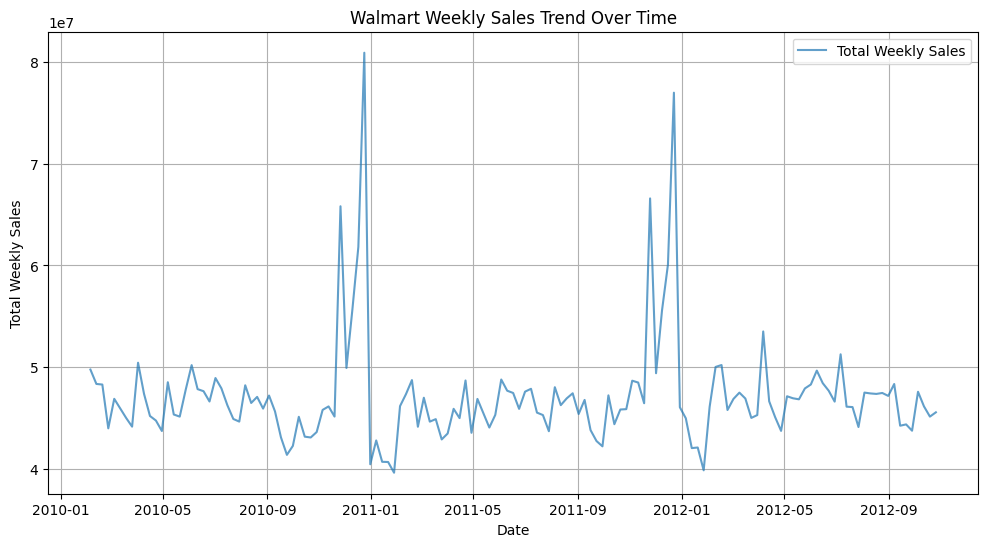

In [33]:
import matplotlib.pyplot as plt

# Aggregate total weekly sales per Date
weekly_sales = train.groupby('Date', as_index=False)['Weekly_Sales'].sum()

# Plot total sales over time
plt.figure(figsize=(12,6))
plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], label='Total Weekly Sales', color='tab:blue', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.title("Walmart Weekly Sales Trend Over Time")
plt.legend()
plt.grid(True)
plt.savefig("Sales_Trends_Over_Time.jpg", format="jpg", dpi=300)
plt.show()


### Sales Distribution by Store

Goal: Find which stores generate the most revenue and spot outliers.

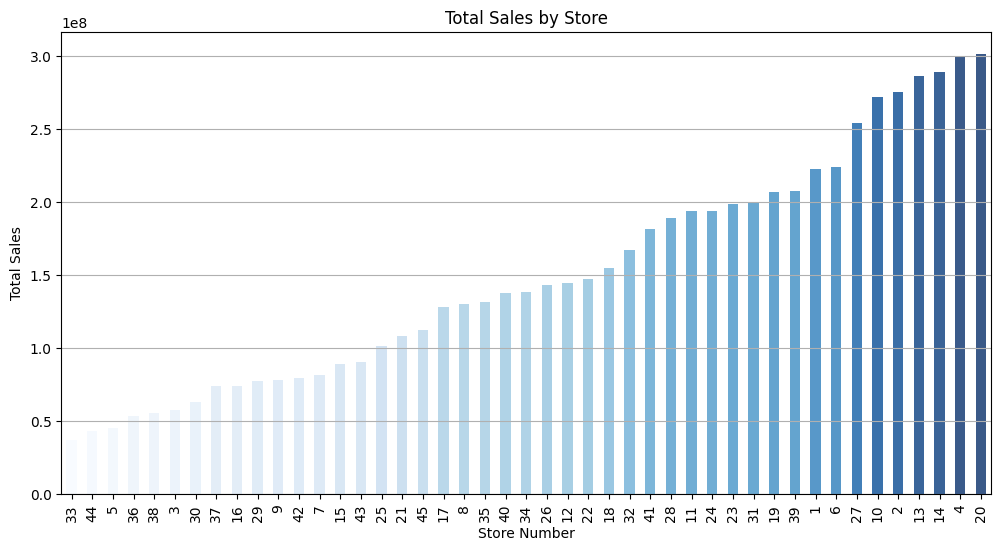

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Aggregate total sales per store
store_sales = train.groupby('Store')['Weekly_Sales'].sum().sort_values()

# Normalize values for color mapping
norm = plt.Normalize(store_sales.min(), store_sales.max())
colors = plt.cm.Blues(norm(store_sales))  # Change 'viridis' to other colormaps (e.g., 'coolwarm', 'plasma', 'cividis')

# Create the bar plot with varying colors
plt.figure(figsize=(12,6))
store_sales.plot(kind='bar', color=colors, alpha=0.8)

# Labels and title
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.title("Total Sales by Store")

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Grid for clarity
plt.grid(axis='y')

# Save and Show
plt.savefig("Sales_Dist_By_Store.jpg", format="jpg", dpi=300)
plt.show()


### Impact of CPI and Unemployment on Sales

Goal: Understand if economic conditions affect Walmart sales.


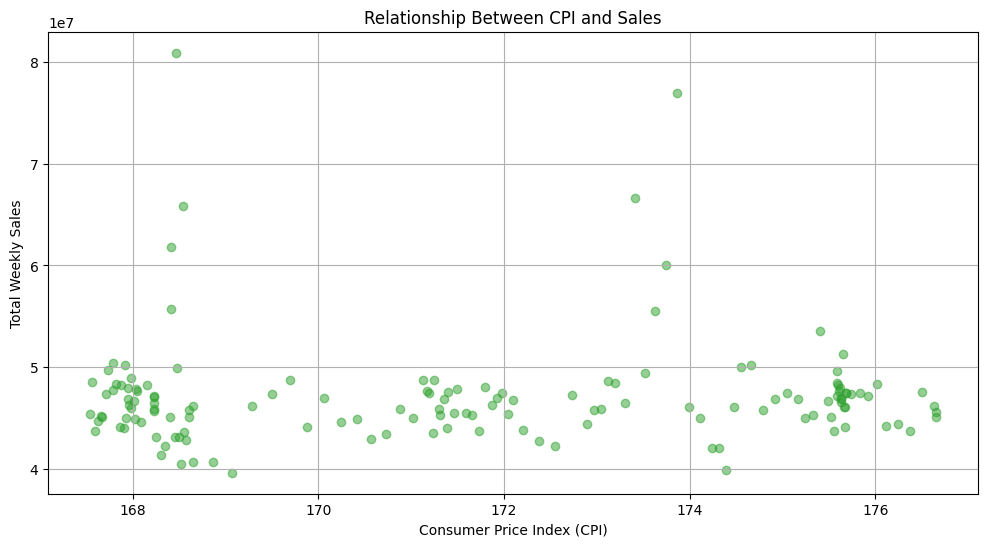

In [35]:
import matplotlib.pyplot as plt

# Aggregate CPI to match sales data (average CPI per Date)
cpi_avg = features.groupby('Date', as_index=False)['CPI'].mean()

# Aggregate Weekly Sales to match CPI data (sum sales per Date)
weekly_sales = train.groupby('Date', as_index=False)['Weekly_Sales'].sum()

# Merge CPI and Sales so both have the same number of rows
cpi_sales = pd.merge(cpi_avg, weekly_sales, on='Date')

# Scatter plot
plt.figure(figsize=(12,6))
plt.scatter(cpi_sales['CPI'], cpi_sales['Weekly_Sales'], color='tab:green', alpha=0.5)
plt.xlabel("Consumer Price Index (CPI)")
plt.ylabel("Total Weekly Sales")
plt.title("Relationship Between CPI and Sales")
plt.grid(True)
plt.savefig(f"Sales_vs_CPI.jpg", format="jpg", dpi=300)
plt.show()


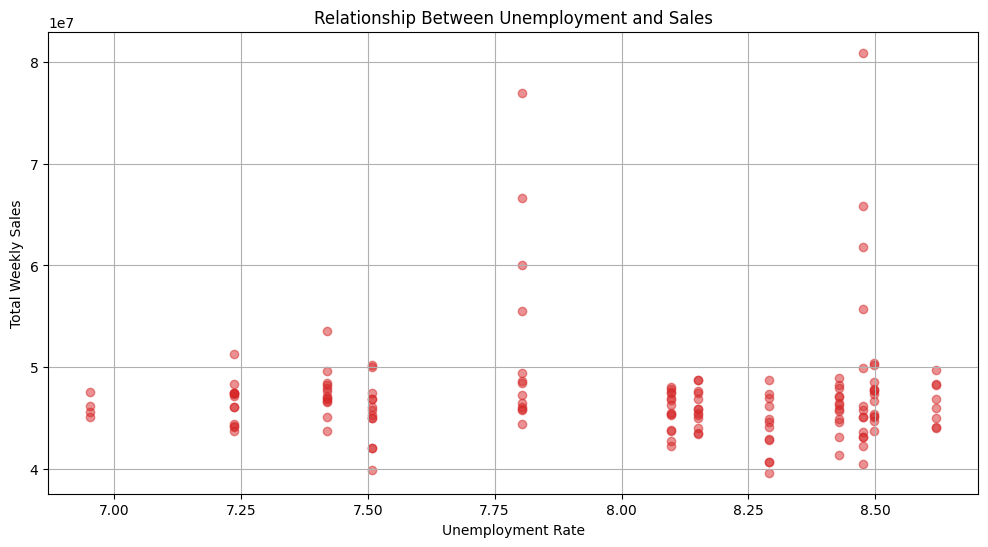

In [36]:
import matplotlib.pyplot as plt

# Aggregate Unemployment to match sales data (average Unemployment per Date)
unemployment_avg = features.groupby('Date', as_index=False)['Unemployment'].mean()

# Aggregate Weekly Sales to match Unemployment data (sum sales per Date)
weekly_sales = train.groupby('Date', as_index=False)['Weekly_Sales'].sum()

# Merge Unemployment and Sales so both have the same number of rows
unemp_sales = pd.merge(unemployment_avg, weekly_sales, on='Date')

# Scatter plot
plt.figure(figsize=(12,6))
plt.scatter(unemp_sales['Unemployment'], unemp_sales['Weekly_Sales'], color='tab:red', alpha=0.5)
plt.xlabel("Unemployment Rate")
plt.ylabel("Total Weekly Sales")
plt.title("Relationship Between Unemployment and Sales")
plt.grid(True)
plt.savefig(f"Sales_vs_Unemployment.jpg", format="jpg", dpi=300)
plt.show()

### Sales Comparison: Holiday vs. Non-Holiday Weeks

Goal: Measure the impact of holidays on sales.

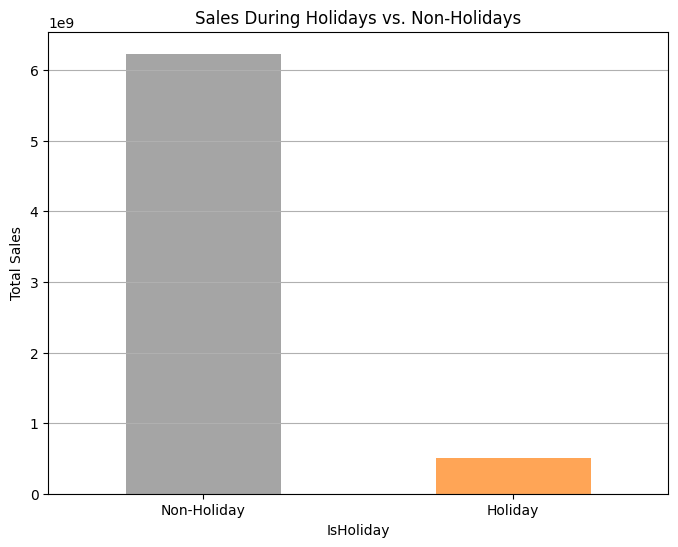

In [37]:
holiday_sales = train.groupby('IsHoliday')['Weekly_Sales'].sum()
plt.figure(figsize=(8,6))
holiday_sales.plot(kind='bar', color=['tab:gray', 'tab:orange'], alpha=0.7)
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.ylabel("Total Sales")
plt.title("Sales During Holidays vs. Non-Holidays")
plt.grid(axis='y')
plt.savefig("Holidat_Sales.jpg", format="jpg", dpi=300)
plt.show()

### Store Performance Over Time (Top 5 & Bottom 5)

Goal: Compare high-performing vs. low-performing stores.

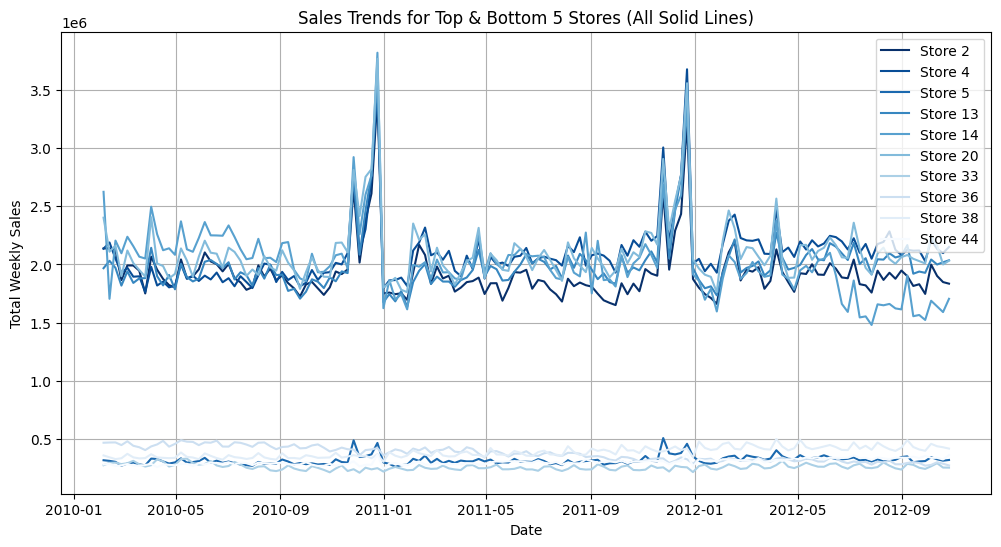

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm  # Import colormap module

# Get total sales per store
store_totals = train.groupby("Store")["Weekly_Sales"].sum().sort_values()

# Select top 5 and bottom 5 stores
top_stores = store_totals.tail(5).index
bottom_stores = store_totals.head(5).index

# Filter the dataset for these stores & aggregate sales per date
top_bottom_df = (
    train[train["Store"].isin(top_stores.union(bottom_stores))]
    .groupby(["Date", "Store"], as_index=False)["Weekly_Sales"]
    .sum()
)

# Sort by Date to ensure proper plotting
top_bottom_df.sort_values("Date", inplace=True)

# Generate a colormap with smooth gradient transition
num_colors = len(top_stores) + len(bottom_stores)  # Number of unique colors needed
colors = cm.Blues_r(np.linspace(0, 1, num_colors))  # Smooth color gradient from viridis

plt.figure(figsize=(12,6))

# Plot both top and bottom stores with solid lines
for i, store in enumerate(top_stores.union(bottom_stores)):  # Combine both lists
    subset = top_bottom_df[top_bottom_df["Store"] == store]
    plt.plot(subset["Date"], subset["Weekly_Sales"], 
             label=f"Store {store}", color=colors[i])

# Formatting
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.title("Sales Trends for Top & Bottom 5 Stores (All Solid Lines)")
plt.legend()
plt.grid(True)
plt.savefig("Top_Bottom_Stores.jpg", format="jpg", dpi=300)
plt.show()


# <span style="color:#5E6997">Conclusion</span> <a class="anchor" id="conclusion"></a>